# LSTM model


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

# Load resampled dataset
df = pd.read_csv("cleaned_bin_data.csv", parse_dates=['timestamp'])

# Select bins for forecasting
bins_to_forecast = [1510830, 1511208, 1511196]
df = df[df['Bin ID'].isin(bins_to_forecast)]

# Filter data up to a specific date (using data prior to 2021-04-25)
train_data = df[df['timestamp'] < "2021-04-25"]

# Function to prepare time series data for LSTM
def prepare_data(series, time_steps=10):
    X, y = [], []
    for i in range(len(series) - time_steps):
        X.append(series[i: i + time_steps])
        y.append(series[i + time_steps])
    return np.array(X), np.array(y)

# Dictionary to store RMSE results for each bin
results = {}

# Define the date range for the last week (actual values)
# Here we assume the last week spans from 2021-04-18 to 2021-04-24 (inclusive)
last_week_start = pd.to_datetime("2021-04-18")
last_week_end = pd.to_datetime("2021-04-25")  # end is non-inclusive

# Train and predict for each bin
for bin_id in bins_to_forecast:
    # Filter and sort training data for the current bin
    bin_train = train_data[train_data['Bin ID'] == bin_id].sort_values(by='timestamp')
    
    # Aggregate to daily values in case there are multiple records per day.
    # Only use the 'timestamp' and 'Fullness' columns to avoid aggregating non-numeric data.
    bin_train_daily = bin_train[['timestamp', 'Fullness']].set_index('timestamp').resample('D').mean().reset_index()
    
    # Normalize the fullness values
    scaler = MinMaxScaler()
    fullness_train = scaler.fit_transform(bin_train_daily[['Fullness']])
    
    # Prepare training data with a specified time step window
    time_steps = 10
    if len(fullness_train) <= time_steps:
        print(f"Not enough data for bin {bin_id}. Skipping.")
        continue
    X_train, y_train = prepare_data(fullness_train, time_steps)
    
    # Reshape input for LSTM [samples, time_steps, features]
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    
    # Build the LSTM model
    model = Sequential([
        LSTM(100, activation='relu', return_sequences=True, input_shape=(time_steps, 1)),
        Dropout(0.2),
        LSTM(100, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    
    # Train the model
    model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=0)
    
    # Predict the next 7 days using a rolling window approach
    predictions = []
    last_sequence = fullness_train[-time_steps:].reshape(1, time_steps, 1)
    for _ in range(7):
        pred = model.predict(last_sequence, verbose=0)
        predictions.append(pred[0, 0])
        # Append the prediction to the sequence and remove the first element
        last_sequence = np.append(last_sequence[:, 1:, :], [[[pred[0, 0]]]], axis=1)
    
    # Inverse transform predictions back to original scale
    predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
    
    # Extract last week actual values from the daily aggregated data
    last_week_data = bin_train_daily[(bin_train_daily['timestamp'] >= last_week_start) &
                                     (bin_train_daily['timestamp'] < last_week_end)]
    last_week_actual = last_week_data['Fullness'].values.reshape(-1, 1)
    
    # Calculate RMSE between the last week actual values and the predictions
    rmse = np.sqrt(mean_squared_error(last_week_actual, predictions))
    results[bin_id] = rmse
    
    # Generate future dates for the predictions plot (next 7 days)
    future_dates = pd.date_range(start="2021-05-04", periods=7, freq='D')
    
    # Plot actual vs predicted with a fixed y-axis from 0 to 10
    plt.figure(figsize=(10, 5))
    plt.plot(last_week_data['timestamp'], last_week_actual, 'bo-', label="Last Week Actual", linewidth=2)
    plt.plot(future_dates, predictions, 'ro--', label="Next Week Predicted", linewidth=2)
    plt.ylim(0, 10)
    plt.title(f"Actual vs Predicted Fullness - Bin {bin_id}")
    plt.xlabel("Date")
    plt.ylabel("Fullness Level")
    plt.legend()
    plt.show()

# Convert results to a DataFrame and print the RMSE table
rmse_df = pd.DataFrame.from_dict(results, orient='index', columns=['RMSE'])
rmse_df.index.name = "Bin ID"
print(rmse_df)


c:\Users\dhyey\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


ValueError: Found input variables with inconsistent numbers of samples: [6, 7]

# ARIMA Model


Last 7 Actual Values for Bin 1510830: [6 6 6 8 6 8 6]


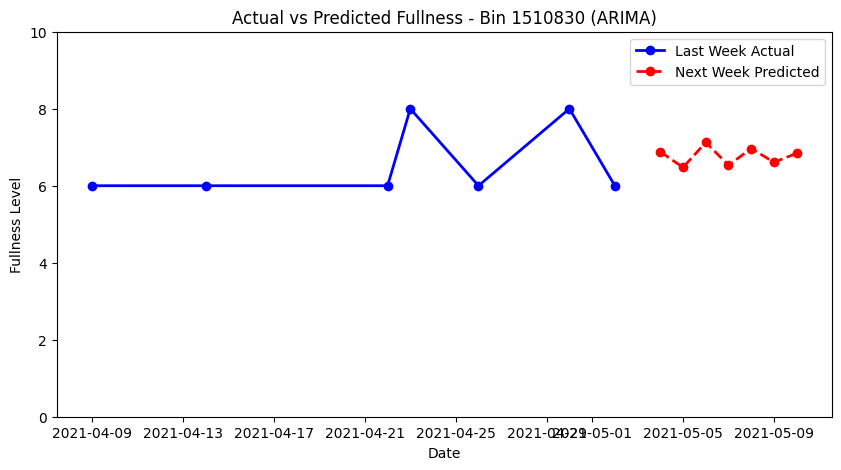

Last 7 Actual Values for Bin 1511208: [ 8  8 10 10  8  8  8]


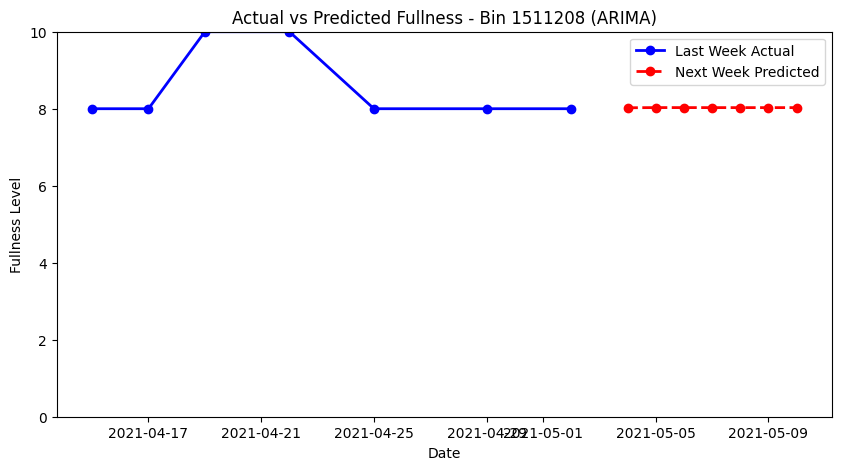

Last 7 Actual Values for Bin 1511196: [10  8  8 10  8 10  8]


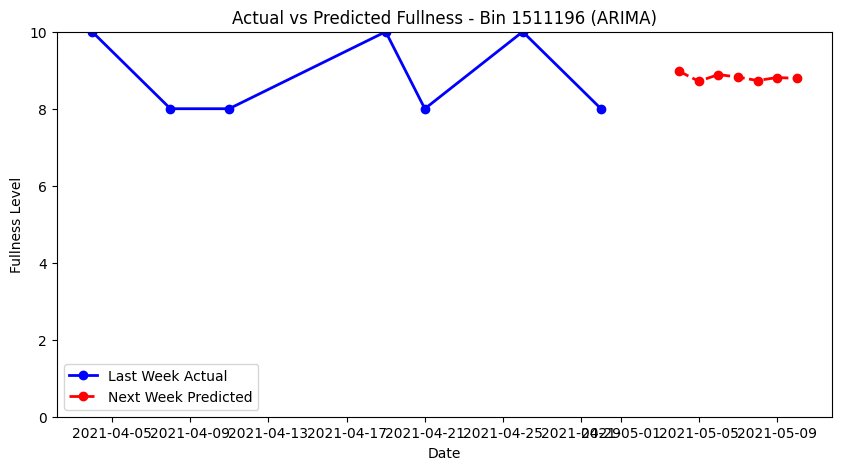

ARIMA Model RMSE for Each Bin:
{1510830: 1.0685362324997985, 1511208: 1.0538572213581567, 1511196: 0.9499699661278823}


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Load cleaned dataset
df = pd.read_csv("cleaned_bin_data.csv", parse_dates=['timestamp'])

# Select bins for forecasting
df = df[df['Bin ID'].isin(bins_to_forecast)]

# Filter data up to May 3, 2021
train_data = df[df['timestamp'] < "2021-05-03"]

# Dictionary to store results
results = {}

# Train and predict for each bin using ARIMA
for bin_id in bins_to_forecast:
    bin_train = train_data[train_data['Bin ID'] == bin_id].sort_values(by='timestamp')

    # Extract fullness values
    fullness_train = bin_train[['Fullness']].values.flatten()

    # Print last 7 actual values to check if they are constant
    print(f"Last 7 Actual Values for Bin {bin_id}: {fullness_train[-7:]}")

    # Select ARIMA order dynamically based on stationarity check
    arima_order = (5, 0, 0) if np.std(fullness_train) < 0.1 else (5, 1, 0)

    # Fit ARIMA model
    model = ARIMA(fullness_train, order=arima_order)
    model_fit = model.fit()

    # Predict the next 7 days
    predictions = model_fit.forecast(steps=7)

    # Extract last 7 days of actual values
    last_week_actual = bin_train['Fullness'].values[-7:]

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(last_week_actual, predictions))
    results[bin_id] = rmse

    # Generate timestamps for prediction
    future_dates = pd.date_range(start="2021-05-04", periods=7, freq='D')

    # Plot actual vs predicted with fixed y-axis
    plt.figure(figsize=(10, 5))
    plt.plot(bin_train['timestamp'].values[-7:], last_week_actual, 'bo-', label="Last Week Actual", linewidth=2)  # Blue solid line
    plt.plot(future_dates, predictions, 'ro--', label="Next Week Predicted", linewidth=2)  # Red dashed line
    plt.ylim(0, 10)  # Fixing y-axis from 0 to 10
    plt.title(f"Actual vs Predicted Fullness - Bin {bin_id} (ARIMA)")
    plt.xlabel("Date")
    plt.ylabel("Fullness Level")
    plt.legend()
    plt.show()

# Print RMSE values
print("ARIMA Model RMSE for Each Bin:")
print(results)


# Exponential Smoothing


Last 7 Actual Values for Bin 1510830: [6 6 6 8 6 8 6]


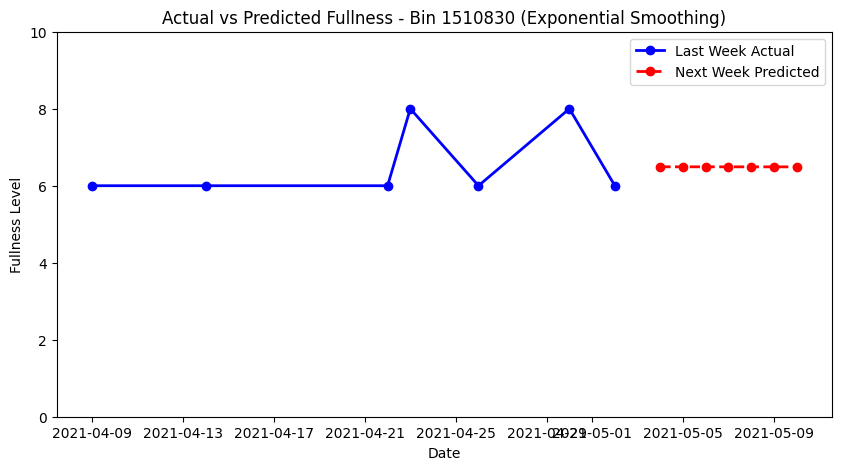

Last 7 Actual Values for Bin 1511208: [ 8  8 10 10  8  8  8]


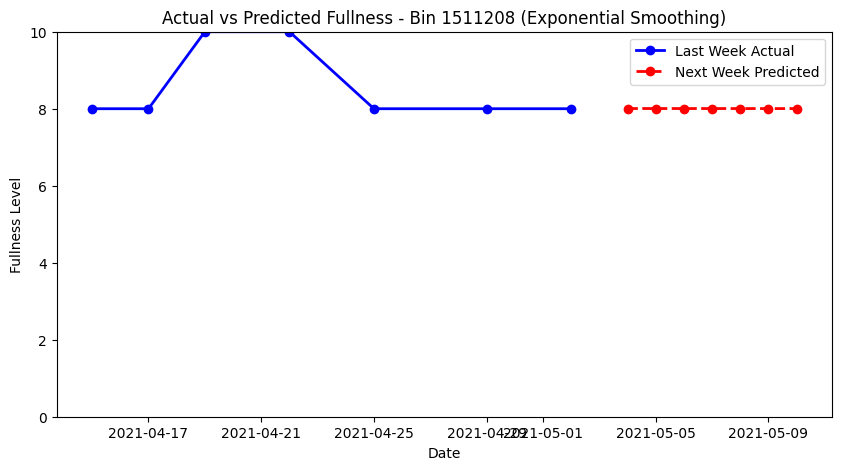

Last 7 Actual Values for Bin 1511196: [10  8  8 10  8 10  8]


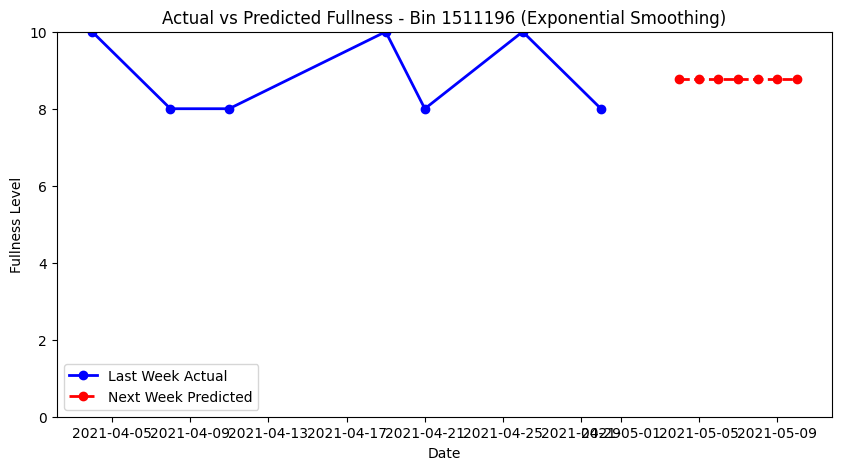

Exponential Smoothing Model RMSE for Each Bin:
{1510830: 0.9072808446278021, 1511208: 1.0665865421101328, 1511196: 0.9934386744864496}


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error

# Load cleaned dataset
df = pd.read_csv("cleaned_bin_data.csv", parse_dates=['timestamp'])

# Select bins for forecasting
df = df[df['Bin ID'].isin(bins_to_forecast)]

# Filter data up to May 3, 2021
train_data = df[df['timestamp'] < "2021-05-03"]

# Dictionary to store results
results = {}

# Train and predict for each bin using Exponential Smoothing (ETS)
for bin_id in bins_to_forecast:
    bin_train = train_data[train_data['Bin ID'] == bin_id].sort_values(by='timestamp')

    # Extract fullness values
    fullness_train = bin_train[['Fullness']].values.flatten()

    # Print last 7 actual values to check if they are constant
    print(f"Last 7 Actual Values for Bin {bin_id}: {fullness_train[-7:]}")

    # Fit Exponential Smoothing Model
    model = ExponentialSmoothing(fullness_train, trend="add", seasonal=None, damped_trend=True)
    model_fit = model.fit()

    # Predict the next 7 days
    predictions = model_fit.forecast(steps=7)

    # Extract last 7 days of actual values
    last_week_actual = bin_train['Fullness'].values[-7:]

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(last_week_actual, predictions))
    results[bin_id] = rmse

    # Generate timestamps for prediction
    future_dates = pd.date_range(start="2021-05-04", periods=7, freq='D')

    # Plot actual vs predicted with fixed y-axis
    plt.figure(figsize=(10, 5))
    plt.plot(bin_train['timestamp'].values[-7:], last_week_actual, 'bo-', label="Last Week Actual", linewidth=2)  # Blue solid line
    plt.plot(future_dates, predictions, 'ro--', label="Next Week Predicted", linewidth=2)  # Red dashed line
    plt.ylim(0, 10)  # Fixing y-axis from 0 to 10
    plt.title(f"Actual vs Predicted Fullness - Bin {bin_id} (Exponential Smoothing)")
    plt.xlabel("Date")
    plt.ylabel("Fullness Level")
    plt.legend()
    plt.show()

# Print RMSE values
print("Exponential Smoothing Model RMSE for Each Bin:")
print(results)


# SARIMA


Last 7 Actual Values for Bin 1510830: [6 6 6 8 6 8 6]


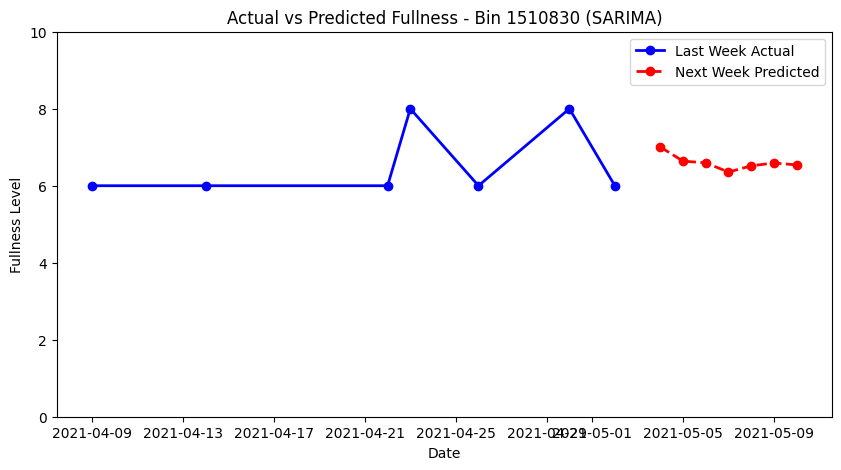

Last 7 Actual Values for Bin 1511208: [ 8  8 10 10  8  8  8]


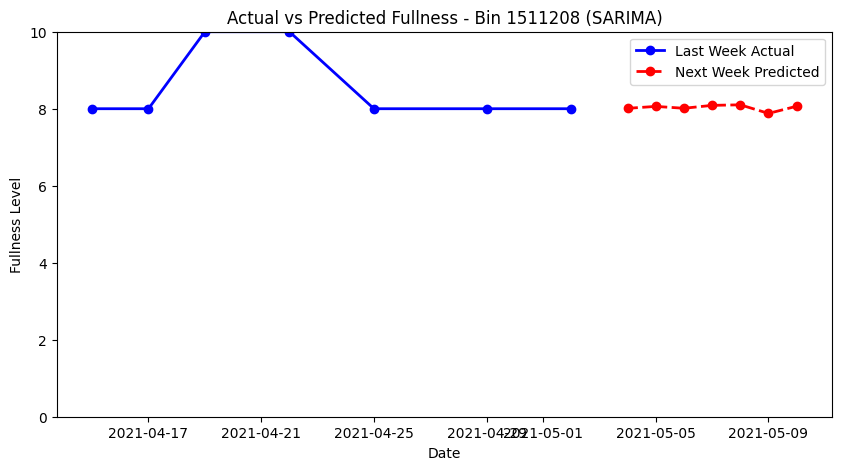

Last 7 Actual Values for Bin 1511196: [10  8  8 10  8 10  8]


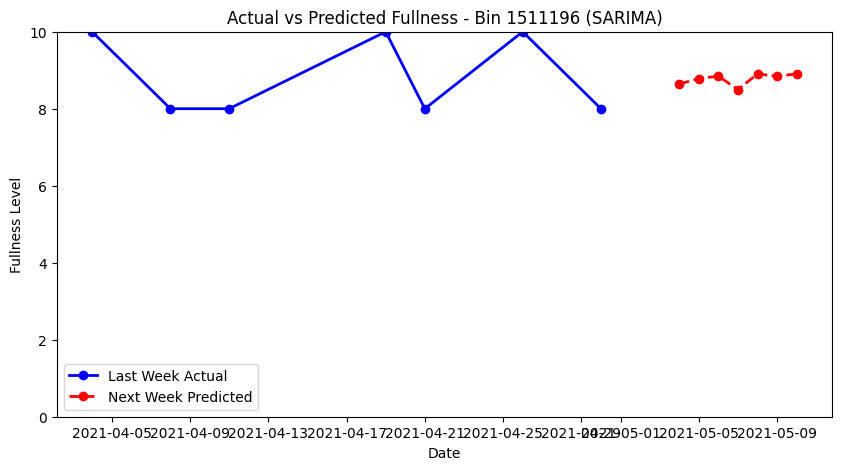

SARIMA Model RMSE for Each Bin:
{1510830: 1.0015393173574783, 1511208: 1.045039852594967, 1511196: 1.0951377350609137}


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

# Load cleaned dataset
df = pd.read_csv("cleaned_bin_data.csv", parse_dates=['timestamp'])

# List of bins to forecast (ensure this variable is defined or modify as needed)
# bins_to_forecast = [list of your bin IDs]
df = df[df['Bin ID'].isin(bins_to_forecast)]

# Filter data up to May 3, 2021
train_data = df[df['timestamp'] < "2021-05-03"]

# Define seasonal period: change to 14 for a 14-day seasonality if needed.
season_length = 7  # or season_length = 14

# Dictionary to store RMSE results for SARIMA
results_sarima = {}

# Train and predict for each bin using SARIMA
for bin_id in bins_to_forecast:
    bin_train = train_data[train_data['Bin ID'] == bin_id].sort_values(by='timestamp')

    # Extract fullness values
    fullness_train = bin_train[['Fullness']].values.flatten()

    # Print last 7 actual values to check consistency
    print(f"Last 7 Actual Values for Bin {bin_id}: {fullness_train[-7:]}")

    # Define SARIMA model parameters: (1,1,1)x(1,1,1,season_length)
    order = (1, 1, 1)
    seasonal_order = (1, 1, 1, season_length)

    # Fit SARIMA model
    model = SARIMAX(fullness_train, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit(disp=False)

    # Predict the next 7 days
    predictions = model_fit.forecast(steps=7)

    # Extract last 7 days of actual values for RMSE calculation
    last_week_actual = bin_train['Fullness'].values[-7:]
    rmse = np.sqrt(mean_squared_error(last_week_actual, predictions))
    results_sarima[bin_id] = rmse

    # Generate timestamps for prediction plotting
    future_dates = pd.date_range(start="2021-05-04", periods=7, freq='D')

    # Plot actual vs predicted with a fixed y-axis (0 to 10)
    plt.figure(figsize=(10, 5))
    plt.plot(bin_train['timestamp'].values[-7:], last_week_actual, 'bo-', label="Last Week Actual", linewidth=2)
    plt.plot(future_dates, predictions, 'ro--', label="Next Week Predicted", linewidth=2)
    plt.ylim(0, 10)
    plt.title(f"Actual vs Predicted Fullness - Bin {bin_id} (SARIMA)")
    plt.xlabel("Date")
    plt.ylabel("Fullness Level")
    plt.legend()
    plt.show()

# Print RMSE values for each bin
print("SARIMA Model RMSE for Each Bin:")
print(results_sarima)
